In [1]:
import os

In [2]:
"""----------------------------------------------------------------------------
LOAD IRIS DATA
----------------------------------------------------------------------------"""
from dask.distributed import Client
import dask.dataframe as dd
from dask import compute
import glob

#from prep import accounts_csvs
#accounts_csvs()

client = Client(n_workers=4)

#from dask.distributed import LocalCluster, Client
#cluster = LocalCluster()
#client = Client(cluster)

filename = os.path.join('./data/iris.csv') #'iris.csv'
print(filename)

./data/iris.csv


In [3]:
df = dd.read_csv(filename)
df.head()
# load and count number of rows
print('LEN',len(df))

LEN 150


In [4]:
#df = dd.read_csv(os.path.join('iris.csv'))
df = dd.read_csv(filename)
print(df)
df.head()

Dask DataFrame Structure:
              sepal_length sepal_width petal_length petal_width variety
npartitions=1                                                          
                   float64     float64      float64     float64  object
                       ...         ...          ...         ...     ...
Dask Name: read-csv, 1 tasks


,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [5]:
df = dd.read_csv(filename, #os.path.join('iris.csv')
                 #parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})
df.tail()

,sepal_length,sepal_width,petal_length,petal_width,variety
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica
149,5.9,3.0,5.1,1.8,Virginica


In [6]:
"""--------------------------------------------------------------------------
Prepare data for ML
-------------------------------------------------------------------------"""
df["variety"] = df.loc[:, "variety"].replace({"Setosa":0, "Versicolor":1, "Virginica":2})
df.tail()

,sepal_length,sepal_width,petal_length,petal_width,variety
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


In [7]:
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [8]:
#import joblib

#with joblib.parallel_backend('dask'):
#    grid_search.fit(trainX, trainy)

In [9]:
"""--------------------------------------------------------------------------
Perform Machine Learning DT
-------------------------------------------------------------------------"""

#Split into training and testing data
train, test = df.random_split([0.80, 0.20])
trainy = train["variety"].compute()
trainX = train.drop("variety",axis=1).compute()
testy = test["variety"].compute()
testX = test.drop("variety",axis=1).compute()

#Create the model
dtClassifer = DecisionTreeClassifier()

import joblib
with joblib.parallel_backend('dask'):
    dtModel = dtClassifer.fit(trainX, trainy)

#Predict on the test data
dtpredictions = dtModel.predict(testX)   

#Evaluate accuracy
from sklearn.metrics import accuracy_score
accuracy_score(testy, dtpredictions)

#Draw a confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(testy, dtpredictions)

array([[ 7,  0,  0],
       [ 0, 14,  1],
       [ 0,  1,  6]], dtype=int64)

In [10]:
accDT = accuracy_score(testy, dtpredictions)
accDT

0.9310344827586207

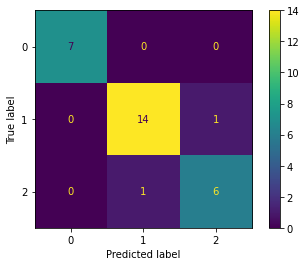

In [11]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(dtModel, testX, testy)

In [12]:
"""--------------------------------------------------------------------------
Perform Machine Learning RF
-------------------------------------------------------------------------"""

#Split into training and testing data
train, test = df.random_split([0.80, 0.20])
trainy = train["variety"].compute()
trainX = train.drop("variety",axis=1).compute()
testy = test["variety"].compute()
testX = test.drop("variety",axis=1).compute()

#Create the model
rfClassifer = RandomForestClassifier()

import joblib
with joblib.parallel_backend('dask'):
    rfModel = rfClassifer.fit(trainX, trainy)

#Predict on the test data
rfpredictions = rfModel.predict(testX)   

#Evaluate accuracy
from sklearn.metrics import accuracy_score
accuracy_score(testy, rfpredictions)

#Draw a confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(testy, rfpredictions)

array([[6, 0, 0],
       [0, 5, 0],
       [0, 0, 7]], dtype=int64)

In [13]:
accRF = accuracy_score(testy, rfpredictions)
accRF

1.0

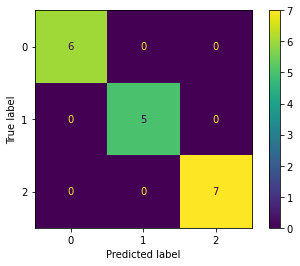

In [14]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rfModel, testX, testy)

In [15]:
"""--------------------------------------------------------------------------
Perform Machine Learning GBT
-------------------------------------------------------------------------"""

#Split into training and testing data
train, test = df.random_split([0.80, 0.20])
trainy = train["variety"].compute()
trainX = train.drop("variety",axis=1).compute()
testy = test["variety"].compute()
testX = test.drop("variety",axis=1).compute()

#Create the model
gbtClassifer = GradientBoostingClassifier()

import joblib
with joblib.parallel_backend('dask'):
    gbtModel = gbtClassifer.fit(trainX, trainy)

#Predict on the test data
gbtpredictions = gbtModel.predict(testX)   

#Evaluate accuracy
from sklearn.metrics import accuracy_score
accuracy_score(testy, gbtpredictions)

#Draw a confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(testy, gbtpredictions)

array([[11,  0,  0],
       [ 0, 10,  1],
       [ 0,  0,  8]], dtype=int64)

In [16]:
accGBT = accuracy_score(testy, gbtpredictions)
accGBT

0.9666666666666667

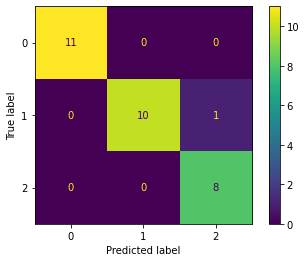

In [17]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(gbtModel, testX, testy)

In [18]:
print("GBT accuracy: ", accGBT)
print("RF accuracy:  ", accRF)
print("DT accuracy:  ", accDT)

GBT accuracy:  0.9666666666666667
RF accuracy:   1.0
DT accuracy:   0.9310344827586207


In [19]:
client.close()

In [20]:
#cluster.close()